## Predicting Prices with a Single-asset Regression Model

### Using historical prices of JPM and GS to predict JPM stock price

In [10]:
from alpha_vantage.timeseries import TimeSeries

     # Update your Alpha Vantage API key here...
ALPHA_VANTAGE_API_KEY = 'LBSD20QX9GCCUD2G'

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
df_jpm, meta_data = ts.get_daily_adjusted(symbol='JPM', outputsize='full')
df_gs, meta_data = ts.get_daily_adjusted(symbol='GS', outputsize='full')

In [11]:
df_gs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5365 entries, 2021-02-26 to 1999-11-01
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1. open               5365 non-null   float64
 1   2. high               5365 non-null   float64
 2   3. low                5365 non-null   float64
 3   4. close              5365 non-null   float64
 4   5. adjusted close     5365 non-null   float64
 5   6. volume             5365 non-null   float64
 6   7. dividend amount    5365 non-null   float64
 7   8. split coefficient  5365 non-null   float64
dtypes: float64(8)
memory usage: 377.2 KB


In [12]:
import pandas as pd
df_x=pd.DataFrame({'GS':df_gs['5. adjusted close']})
jpm_prices=df_jpm['5. adjusted close']

## Write the Linear Regression Model [OLS]

In [30]:
from sklearn.linear_model import LinearRegression
class LinearRegressionModel(object):
    def __init__(self):
        self.df_result=pd.DataFrame(columns=['Actual','Predicted'])
    def get_model(self):
        return LinearRegression(fit_intercept=False)
    def get_prices_since(self,df,date_since,lookback):
        index=df.index.get_loc(date_since)
        return df.iloc[index-lookback:index]
    def learn(self,df,ys,start_date,end_date,lookback_period=20):
        model=self.get_model()
        df.sort_index(inplace=True)
        for date in df[start_date:end_date].index:
            x=self.get_prices_since(df,date,lookback_period)
            y=self.get_prices_since(ys,date,lookback_period)
            model.fit(x,y.ravel()) # fit the model
            # predict the current period
            x_current=df.loc[date].values
            [y_pred]=model.predict([x_current])
            # store the prediction
            new_index=pd.to_datetime(date,format='%Y-%m-%d')
            y_actual=ys.loc[date]
            self.df_result.loc[new_index]=[y_actual, y_pred]

## Run It and Plot it !!!

In [33]:
linear_reg_model=LinearRegressionModel()
linear_reg_model.learn(df_x,jpm_prices,start_date='2018',end_date='2019',lookback_period=20)

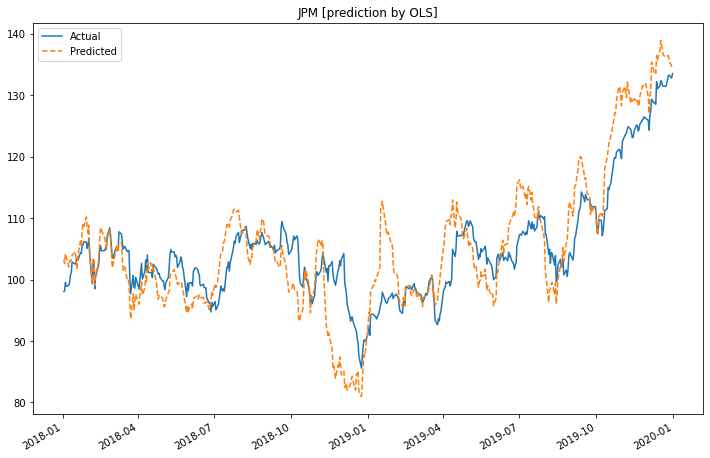

In [34]:
%matplotlib inline
linear_reg_model.df_result.plot(title='JPM [prediction by OLS]',style=['-', '--'],figsize=(12,8));

## Risk Metrics for Measuring Prediction Performance

### Mean Absolute Error (MAE)

In [35]:
from sklearn.metrics import mean_absolute_error
actual=linear_reg_model.df_result['Actual']
predicted=linear_reg_model.df_result['Predicted']
mae=mean_absolute_error(actual,predicted)
print('mean absolute error:', mae)


mean absolute error: 4.241691530083501


### Mean Square Error (MSE)

In [36]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(actual,predicted)
print('mean squared error:',mse)

mean squared error: 29.931406857724674


### Explained Variance Score

In [37]:
from sklearn.metrics import explained_variance_score
eva=explained_variance_score(actual,predicted)
print('explained variance score:',eva)

explained variance score: 0.6049533897577586


### R^2

In [38]:
from sklearn.metrics import r2_score
r2=r2_score(actual,predicted)
print('r2 score:',r2)

r2 score: 0.6006623289233419


## Ridge Regression [L2 Regularization]

In [48]:
# penalizing the sume of squares of the model coefficients
from sklearn.linear_model import Ridge
class RidgeRegressionModel(LinearRegressionModel):
    def get_model(self):
        return Ridge(alpha=0.5)
ridge_reg_model=RidgeRegressionModel()
ridge_reg_model.learn(df_x,jpm_prices,start_date='2018',end_date='2019',lookback_period=20)

In [49]:
from sklearn.metrics import(accuracy_score,mean_absolute_error,explained_variance_score,r2_score)
def print_regression_metrics(df_result):
    actual=list(df_result['Actual'])
    predicted=list(df_result['Predicted'])
    print('mean_absolute_error:',mean_absolute_error(actual,predicted))
    print('mean_squared_error:',mean_squared_error(actual,predicted))
    print('explained_var_score:',explained_variance_score(actual,predicted))
    print('r2_score:',r2_score(actual,predicted))

In [50]:
print_regression_metrics(ridge_reg_model.df_result)

mean_absolute_error: 2.3208573795728484
mean_squared_error: 9.269898615082298
explained_var_score: 0.8799470179116999
r2_score: 0.8763232299216721


## Predicting Returns with Cross-asset Momentum Model

### Using 1,3,6,12-month lagged returns of DAX, Treasury Bond, US Dollar index and Gold to predict JPM

In [58]:
### Preparing independeng variables:
from alpha_vantage.timeseries import TimeSeries

     # Update your Alpha Vantage API key here...
ALPHA_VANTAGE_API_KEY = 'LBSD20QX9GCCUD2G'

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
df_dax, meta_data = ts.get_daily_adjusted(symbol='DAX', outputsize='full')
df_gld, meta_data = ts.get_daily_adjusted(symbol='GLD', outputsize='full')
df_dxy, meta_data = ts.get_daily_adjusted(symbol='UUP', outputsize='full')
df_ief, meta_data = ts.get_daily_adjusted(symbol='IEF', outputsize='full')


In [62]:
import pandas as pd
df_assets=pd.DataFrame({'DAX':df_dax['5. adjusted close'],
                       'GLD':df_gld['5. adjusted close'],
                       'DXY':df_dxy['5. adjusted close'],
                       'IEF':df_ief['5. adjusted close'],}).dropna()
## calaulate the lagged percentage returns of dataset
df_assets_1m=df_assets.pct_change(periods=20)
df_assets_1m.columns=['%s_1m'%col for col in df_assets.columns]

df_assets_3m=df_assets.pct_change(periods=60)
df_assets_3m.columns=['%s_3m'%col for col in df_assets.columns]

df_assets_6m=df_assets.pct_change(periods=120)
df_assets_6m.columns=['%s_6m'%col for col in df_assets.columns]

df_assets_12m=df_assets.pct_change(periods=240)
df_assets_12m.columns=['%s_12m'%col for col in df_assets.columns]

In [63]:
df_lagged=df_assets_1m.join(df_assets_3m).join(df_assets_6m).join(df_assets_12m).dropna()

In [64]:
df_lagged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1357 entries, 2015-10-07 to 2021-02-26
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DAX_1m   1357 non-null   float64
 1   GLD_1m   1357 non-null   float64
 2   DXY_1m   1357 non-null   float64
 3   IEF_1m   1357 non-null   float64
 4   DAX_3m   1357 non-null   float64
 5   GLD_3m   1357 non-null   float64
 6   DXY_3m   1357 non-null   float64
 7   IEF_3m   1357 non-null   float64
 8   DAX_6m   1357 non-null   float64
 9   GLD_6m   1357 non-null   float64
 10  DXY_6m   1357 non-null   float64
 11  IEF_6m   1357 non-null   float64
 12  DAX_12m  1357 non-null   float64
 13  GLD_12m  1357 non-null   float64
 14  DXY_12m  1357 non-null   float64
 15  IEF_12m  1357 non-null   float64
dtypes: float64(16)
memory usage: 180.2 KB


In [65]:
## Preparing the target variables:
y=jpm_prices.pct_change().dropna()

In [66]:
## multi-asset linear regression model
multi_linear_model=LinearRegressionModel()
multi_linear_model.learn(df_lagged,y,start_date='2018',end_date='2019',lookback_period=10)

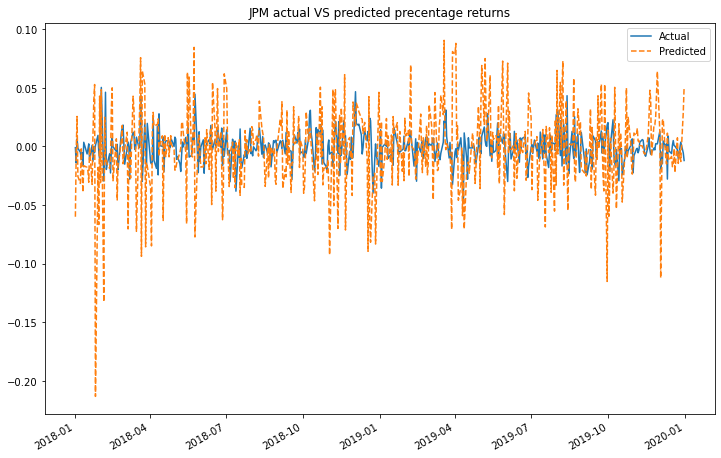

In [68]:
## plot
multi_linear_model.df_result.plot(title='JPM actual VS predicted precentage returns',style=['-', '--'],figsize=(12,8));

In [69]:
print_regression_metrics(multi_linear_model.df_result)

mean_absolute_error: 0.02682011730997706
mean_squared_error: 0.0013199961906053483
explained_var_score: -6.885291852422347
r2_score: -6.895348973263765


In [70]:
# R2 is negative, meaning that the model performs below average

## Bagging Regressor [Decision Tree Model]

In [75]:
from sklearn.ensemble import BaggingRegressor
class BaggingRegressorModel(LinearRegressionModel):
    def get_model(self):
        return BaggingRegressor(n_estimators=20,random_state=0)

In [76]:
bagging=BaggingRegressorModel()
bagging.learn(df_lagged,y,start_date='2018',end_date='2019',lookback_period=10)
print_regression_metrics(bagging.df_result)

mean_absolute_error: 0.011236933694433305
mean_squared_error: 0.0002232367478394967
explained_var_score: -0.3344680399334805
r2_score: -0.33525538966973656


## Predicting Trends with Classification-based Machine Learning

### with Boolean variables: Ture means an increase or unchage from previous trading day

In [77]:
# Prepare the target variables:
import numpy as np
y_direction=y>=0
y_direction.head(3)

date
2021-02-25     True
2021-02-24     True
2021-02-23    False
Name: 5. adjusted close, dtype: bool

In [78]:
flags=list(y_direction.unique())
flags.sort()
print(flags)

[False, True]


In [79]:
# prepare the input variables
df_input=df_assets_1m.join(df_assets_3m).dropna()
df_input.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1537 entries, 2015-01-21 to 2021-02-26
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DAX_1m  1537 non-null   float64
 1   GLD_1m  1537 non-null   float64
 2   DXY_1m  1537 non-null   float64
 3   IEF_1m  1537 non-null   float64
 4   DAX_3m  1537 non-null   float64
 5   GLD_3m  1537 non-null   float64
 6   DXY_3m  1537 non-null   float64
 7   IEF_3m  1537 non-null   float64
dtypes: float64(8)
memory usage: 108.1 KB


### Logistic Regression

In [80]:
from sklearn.linear_model import LogisticRegression
class LogisticRegressionModel(LinearRegressionModel):
    def get_model(self):
        return LogisticRegression(solver='lbfgs')

In [82]:
logistic_reg_model=LogisticRegressionModel()
logistic_reg_model.learn(df_input,y_direction,start_date='2018',end_date='2019',lookback_period=100)
logistic_reg_model.df_result.head()

,Actual,Predicted
2018-01-02,False,False
2018-01-03,False,False
2018-01-04,True,False
2018-01-05,False,False
2018-01-08,False,False


## Risk Metrics for Measuring Classification-based Predictions

### Confusion Matrix

In [83]:
from sklearn.metrics import confusion_matrix
df_result=logistic_reg_model.df_result
actual=list(df_result['Actual'])
predicted=list(df_result['Predicted'])
matrix=confusion_matrix(actual,predicted)

In [84]:
print(matrix)

[[125 136]
 [112 130]]


Text(0.5, 1.0, 'JPM percentage returns')

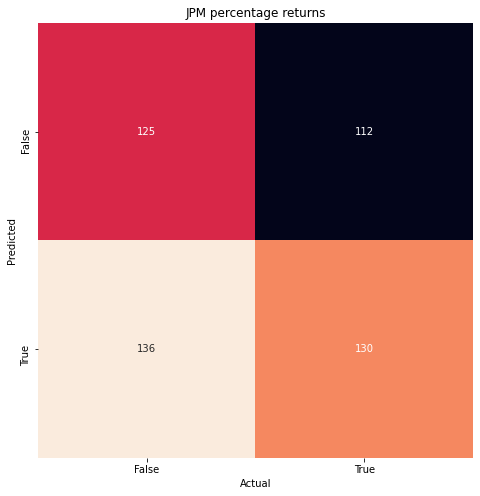

In [85]:
# Visualize with Seaborn
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(figsize=(12,8))
sns.heatmap(matrix.T,square=True,annot=True,fmt='d',cbar=False,xticklabels=flags,yticklabels=flags)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('JPM percentage returns')


### Accuracy Score

In [86]:
from sklearn.metrics import accuracy_score
print('accuracy_score:',accuracy_score(actual,predicted))

accuracy_score: 0.5069582504970179


### Precision Score

In [87]:
from sklearn.metrics import precision_score
print('precision_score:',precision_score(actual,predicted))

precision_score: 0.48872180451127817


### Recall Score

In [88]:
from sklearn.metrics import recall_score
print('recall_score:',recall_score(actual,predicted))

recall_score: 0.5371900826446281


In [89]:
from sklearn.metrics import f1_score
print('f1_score:',f1_score(actual,predicted))

f1_score: 0.5118110236220472


## Support Vector Classofier (SVC)

In [91]:
from sklearn.svm import SVC
class SVCModel(LogisticRegressionModel):
    def get_model(self):
        return SVC(C=1000,gamma='auto')

In [92]:
svc_model=SVCModel()
svc_model.learn(df_input,y_direction,start_date='2018',end_date='2019',lookback_period=100)

In [96]:
df_result=svc_model.df_result
actual=list(df_result['Actual'])
predicted=list(df_result['Predicted'])
print('Accuracy_score:',accuracy_score(actual,predicted))
print('Precision_score:',precision_score(actual,predicted))
print('Recall_score:',recall_score(actual,predicted))
print('f1_score:',f1_score(actual,predicted))

Accuracy_score: 0.49105367793240556
Precision_score: 0.46956521739130436
Recall_score: 0.4462809917355372
f1_score: 0.4576271186440678
